<a href="https://colab.research.google.com/github/maheshyadav007/research/blob/main/NPF_NPV_Experiments_wandb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torchviz
!pip install wandb --upgrade

In [ ]:
import torch
from torch import nn
from torch.utils.data import Dataset
import numpy as np
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torchviz import make_dot
import wandb
device = "cuda" if torch.cuda.is_available() else "cpu"


In [ ]:
wandb.login()

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, training_data):
        self.size = len(training_data)
        X, Y = training_data[0]
        self.x = torch.ones(self.size, X.shape[0],X.shape[1], X.shape[2] )
        self.y = torch.tensor([x for _,x in training_data])

    def __len__(self):
        return (self.size)

    def __getitem__(self, idx):
        #print(self.x[idx].shape,self.y[idx].shape )
        return self.x[idx], self.y[idx]

**MNIST**

In [ ]:
# Download training data from open datasets.
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [ ]:
labels_map = {
    0: "0",
    1: "1",
    2: "2",
    3: "3",
    4: "4",
    5: "5",
    6: "6",
    7: "7",
    8: "8",
    9: "9",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
counter = 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[counter]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
    counter += 1
plt.show()


In [ ]:
#x_dummy_dataloader_all = DataLoader(CustomDataset(training_data), batch_size=60000, shuffle=False)

In [ ]:
#batch_size = 60000
#npv_features = get_activation_output(train_dataloader_all, npv_model)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
batch_size = 32
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
train_dataloader_all = DataLoader(training_data, batch_size=60000, shuffle=False)
x_dummy_dataloader = DataLoader(CustomDataset(training_data), batch_size=batch_size, shuffle=False)

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    correct = 0
    for batch, (x,y) in enumerate(dataloader):
        X, y = x.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch%100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f} Batch:{batch} [{current:>5d}/{size:>5d}]")
    return pred

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

class FCNeuralNet(nn.Module):
    def __init__(self):
        super(FCNeuralNet, self).__init__()
        
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, 128)
        self.fc5 = nn.Linear(128, 128)
        self.fc6 = nn.Linear(128, 10)

    def forward(self, x, batch = None):
        x = self.flatten(x)
        x = self.fc1(x)
        o1 = torch.relu(x)
        x = self.fc2(o1)
        o2 = torch.relu(x)
        x = self.fc3(o2)
        o3 = torch.relu(x)
        x = self.fc4(o3)
        o4 = torch.relu(x)
        x = self.fc5(o4)
        o5 = torch.relu(x)
        x = self.fc6(o5)
        x = F.log_softmax(x, dim=1)
        return x

model = FCNeuralNet().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr = 1e-1) 


In [ ]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    pred = train(train_dataloader,model, loss_fn, optimizer)
    test(test_dataloader,model, loss_fn)
print("Done!")


In [ ]:
class NPKNeuralNetwork(nn.Module):
    def __init__(self):
        super(NPKNeuralNetwork, self).__init__()
        
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, 128)
        self.fc5 = nn.Linear(128, 128)
        self.fc6 = nn.Linear(128, 10)

    def forward(self, x, batch = None):
        x = self.flatten(x)
        x = self.fc1(x)
        o1 = torch.relu(x)
        x = self.fc2(o1)
        o2 = torch.relu(x)
        x = self.fc3(o2)
        o3 = torch.relu(x)
        x = self.fc4(o3)
        o4 = torch.relu(x)
        x = self.fc5(o4)
        o5 = torch.relu(x)
        x = self.fc6(o5)
        x = F.log_softmax(x, dim=1)
        return x, [o1,o2,o3,o4,o5]


In [ ]:

class NPVNeuralNetwork(nn.Module):
    def __init__(self):
        super(NPVNeuralNetwork, self).__init__()
    
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, 128)
        self.fc5 = nn.Linear(128, 128)
        self.fc6 = nn.Linear(128, 10)
        self.soft_relu1 = Soft_Relu()
        self.soft_relu2 = Soft_Relu()
        self.soft_relu3 = Soft_Relu()
        self.soft_relu4 = Soft_Relu()
        self.soft_relu5 = Soft_Relu()

    def forward(self, x,npk_features, batch = None):
        x = self.flatten(x)
        x = self.fc1(x)
        o1 = self.soft_relu1(x, 0, batch, npk_features)
        x = self.fc2(o1)
        o2 = self.soft_relu2(x,1, batch, npk_features)
        x = self.fc3(o2)
        o3 = self.soft_relu3(x,2, batch, npk_features)
        x = self.fc4(o3)
        o4 = self.soft_relu4(x,3, batch, npk_features)
        x = self.fc5(o4)
        o5 = self.soft_relu5(x,4, batch, npk_features)
        x = self.fc6(o5)
        F.log_softmax(x, dim=1)
        return x,  [o1,o2,o3,o4,o5]



In [ ]:
def soft_relu_gate(x, beta, idx, batch, npk_features):
  global batch_size
  
  start = batch_size*batch
  end = batch_size * (batch+1)
  if x.shape[0] < batch_size:
    end = -1
 
  #out = beta*torch.sign(npk_features[idx])
  out = beta*(npk_features[idx])
  #print(idx,x.shape[0], start, end, out.shape)
  return out
  
class Soft_Relu(nn.Module):
    def __init__(self, beta = 4):
        super(Soft_Relu,self).__init__()
        self.beta = beta#Parameter(torch.tensor(.5), requires_grad = True) 
       
        #self.beta.requiresGrad = True 

    def forward(self, x, idx, batch, npk_features):
      #Soft Relu
      out = torch.mul(x,torch.sigmoid(soft_relu_gate(x, self.beta, idx, batch, npk_features)))
      return out
      
      #Hard Relu
      #return torch.mul(x,torch.sign(npk_features[idx]))

In [ ]:
def train_decoupled(X1_dataloader,X2_dataloader, npk_model, npv_model, loss_fn, optimizer):
    size = len(X1_dataloader.dataset)
    correct = 0
    for batch, ((X1, y1), (X2,y2)) in enumerate(zip(X1_dataloader, X2_dataloader)):
        X1, y1 = X1.to(device), y1.to(device)
        X2, y2 = X2.to(device), y2.to(device)
        #print(X.shape,y.shape)
        # Compute prediction error
        _, npk_features = npk_model(X1, batch)
        pred, npv_features = npv_model(X2, npk_features, batch)

        loss = loss_fn(pred, y1)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        #print(npv_model.fc2.weight.grad_fn, npv_model.fc2.weight.grad)
        optimizer.step()
        #print("IN inner loop : ", npk_model.fc1.weight.grad_fn, npk_model.fc2.weight.grad)

        if batch%100 == 0:
            #correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            loss, current = loss.item(), batch * len(X1)
            print(f"loss: {loss:>7f} Batch:{batch} [{current:>5d}/{size:>5d}]")
    return pred

In [ ]:
def test_decoupled(dataloader, npk_model, npv_model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    npk_model.eval()
    npv_model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            _, npk_features = npk_model(X, batch)
            pred, npv_features = npv_model(X, npk_features, batch)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [ ]:
npk_model = NPKNeuralNetwork().to(device)
npv_model = NPVNeuralNetwork().to(device)

In [ ]:
npk_model.load_state_dict(model.state_dict())
#npv_model.load_state_dict(npk_model.state_dict())

<All keys matched successfully>

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD([
                {'params': npk_model.parameters()},
                {'params': npv_model.parameters()}],
                lr = 1e-1) 

In [ ]:
for param in npv_model.parameters():
  param.requires_grad = False

In [ ]:
epochs = 50
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    
    pred = train_decoupled(train_dataloader,train_dataloader,npk_model, npv_model, loss_fn, optimizer)
    test_decoupled(test_dataloader,npk_model, npv_model, loss_fn)
    #print("IN outer loop : ",npk_model.fc1.weight.grad, npk_model.fc3.weight.grad,npk_model.fc5.weight.grad )
print("Done!")

In [ ]:
test_decoupled(train_dataloader,npk_model, npv_model, loss_fn)

Test Error: 
 Accuracy: 60.5%, Avg loss: 2.210951 



In [ ]:
#torch.save(npk_model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/npk.pt')


In [ ]:
#torch.save(npv_model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/npv.pt')


In [ ]:
make_dot(pred, params=dict(npk_model.named_parameters()))

In [ ]:
make_dot(pred, params=dict(npv_model.named_parameters()))

**CIFAR**

Conv Net


In [ ]:
# Download training data from open datasets.
cifar_training_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
cifar_test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


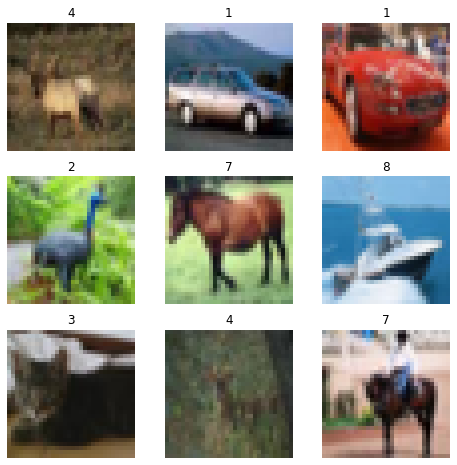

In [ ]:
labels_map = {
    0: "0",
    1: "1",
    2: "2",
    3: "3",
    4: "4",
    5: "5",
    6: "6",
    7: "7",
    8: "8",
    9: "9",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
counter = 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(cifar_training_data), size=(1,)).item()
    img, label = cifar_training_data[counter]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(np.transpose(img, (1, 2, 0)))
    counter += 1
plt.show()


In [ ]:
batch_size = 32
cifar_train_dataloader = DataLoader(cifar_training_data, batch_size=batch_size, shuffle=True)
cifar_test_dataloader = DataLoader(cifar_test_data, batch_size=batch_size, shuffle=True)
cifar_train_dummy_dataloader = DataLoader(CustomDataset(cifar_training_data), batch_size=batch_size, shuffle=False)

In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
      super(ConvNet, self).__init__()

      self.conv1 = nn.Conv2d(3, 128, kernel_size = 3, stride = 1)
      self.conv2 = nn.Conv2d(128, 128, kernel_size = 3, stride = 1)
      self.conv3 = nn.Conv2d(128, 128, kernel_size = 3, stride = 1)
      self.conv4 = nn.Conv2d(128, 128, kernel_size = 3, stride = 1)
      # First fully connected layer
      
      self.avgpool = nn.AvgPool2d(12)
      self.fc1 = nn.Linear(128*2*2, 256)
      self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
      x = F.relu(self.conv1(x))
      x = F.relu(self.conv2(x))
      x = F.relu(self.conv3(x))
      x = F.relu(self.conv4(x))
      x = self.avgpool(x)
      x = x.view(x.shape[0],-1)
      x = self.fc1(x)
      x = self.fc2(x)
      out = F.log_softmax(x, dim=1)
      #print(out.shape)
      return out

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    correct = 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        #print(X.shape,y.shape)
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch%100 == 0:
            #correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f} Batch:{batch} [{current:>5d}/{size:>5d}]")

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [ ]:
conv_model = ConvNet()
conv_model = conv_model.to(device)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(conv_model.parameters(), lr=3e-4)


In [ ]:
#loss_fn = nn.CrossEntropyLoss()
#optimizer = torch.optim.SGD(conv_model.parameters(), lr=0.01)

In [ ]:
epochs = 30
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(cifar_train_dataloader,conv_model, loss_fn, optimizer)
    test(cifar_test_dataloader,conv_model, loss_fn)
print("Done!")

In [ ]:
def apply_gate(x, beta, idx, batch, npk_features):
  global batch_size
  
  start = batch_size*batch
  end = batch_size * (batch+1)
  if x.shape[0] < batch_size:
    end = -1
 
  #out = beta*torch.sign(npk_features[idx])
  out = beta*(npk_features[idx])
  #print(idx,x.shape[0], start, end, out.shape)
  return out
  
class Gate(nn.Module):
    def __init__(self,relu_type, beta = 4):
        super(Gate,self).__init__()
        self.beta = beta#Parameter(torch.tensor(.5), requires_grad = True) 
        self.relu_type = relu_type
        #self.beta.requiresGrad = True 

    def forward(self, x, idx, batch, npk_features):
      if self.relu_type == "soft":
        #Soft Relu
        return torch.mul(x,torch.sigmoid(apply_gate(x, self.beta, idx, batch, npk_features)))
      else:
        #Hard Relu
        return torch.mul(x,torch.sign(npk_features[idx]))

In [ ]:
class NPKConvNet(nn.Module):
    def __init__(self):
      super(NPKConvNet, self).__init__()
      self.conv1 = nn.Conv2d(3, 1000, 3, 1)
      self.conv2 = nn.Conv2d(1000, 1000, 3, 1)
      self.conv3 = nn.Conv2d(1000, 1000, 3, 1)
      self.conv4 = nn.Conv2d(1000, 1000, 3, 1)
     
      self.avgpool = nn.AvgPool2d(12)
      self.fc1 = nn.Linear(1000*2*2, 256)
      self.fc2 = nn.Linear(256, 10)

    def forward(self, x, batch = None):
      o1 = F.relu(self.conv1(x))
      o2 = F.relu(self.conv2(o1))
      o3 = F.relu(self.conv3(o2))
      o4 = F.relu(self.conv4(o3))
      x = self.avgpool(o4)
      x = x.view(x.shape[0],-1)
      x = self.fc1(x)
      x = self.fc2(x)
      out = x#F.log_softmax(x, dim=1)
      #print(out.shape)
      return out, [o1,o2,o3,o4]

In [ ]:
class NPVConvNet(nn.Module):
    def __init__(self, relu_type):
      super(NPVConvNet, self).__init__()
      self.conv1 = nn.Conv2d(3, 1000, 3, 1)
      self.conv2 = nn.Conv2d(1000, 1000, 3, 1)
      self.conv3 = nn.Conv2d(1000, 1000, 3, 1)
      self.conv4 = nn.Conv2d(1000, 1000, 3, 1)
     
      self.avgpool = nn.AvgPool2d(12)
      self.fc1 = nn.Linear(1000*2*2, 1000)
      self.fc2 = nn.Linear(1000, 10)
      self.gate1 = Gate(relu_type)
      self.gate2 = Gate(relu_type)
      self.gate3 = Gate(relu_type)
      self.gate4 = Gate(relu_type)

    def forward(self, x, batch, npk_features):
      x = self.conv1(x)
      o1 = self.gate1(x, 0, batch, npk_features)
      x = self.conv2(o1)
      o2 = self.gate2(x, 1, batch, npk_features)
      x = self.conv3(o2)
      o3 = self.gate3(x, 2, batch, npk_features)
      x = self.conv4(o3)
      o4 = self.gate4(x, 3, batch, npk_features)
      #print(o4.shape)
      x = self.avgpool(o4)

      x = x.view(x.shape[0],-1)
      
      x = self.fc1(x)
      x = self.fc2(x)
     
      out = x#F.log_softmax(x, dim=1)
      #print(out.shape)
      return out, [o1,o2,o3,o4]

In [ ]:
def train_decoupled(X1_dataloader,X2_dataloader, npk_model, npv_model, loss_fn, optimizer):
    size = len(X1_dataloader.dataset)
    correct = 0
    for batch, ((X1, y1), (X2,y2)) in enumerate(zip(X1_dataloader, X2_dataloader)):
        X1, y1 = X1.to(device), y1.to(device)
        X2, y2 = X2.to(device), y2.to(device)
        #print(X.shape,y.shape)
        # Compute prediction error
        _, npk_features = npk_model(X1, batch)
        pred, npv_features = npv_model(X2, batch, npk_features)
        #print(pred.shape, y1.shape)
        loss = loss_fn(pred, y1)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #print(npk_model.fc5.weight.grad)
        
        if batch%100 == 0:
            #correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            loss, current = loss.item(), batch * len(X1)
            print(f"loss: {loss:>7f} Batch:{batch} [{current:>5d}/{size:>5d}]")
            wandb.log({"loss": loss})
    return pred

In [ ]:
def test_decoupled(data_type,dataloader, npk_model, npv_model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    npk_model.eval()
    npv_model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            _, npk_features = npk_model(X, batch)
            pred, npv_features = npv_model(X, batch, npk_features)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    
    if data_type == "training":
      wandb.log({"train_acc": 100*correct, "train_loss" : test_loss })
    else:
      wandb.log({"test_acc": 100*correct, "test_loss" : test_loss })
    

In [ ]:
#npk_model.load_state_dict(conv_model.state_dict())

In [ ]:
def make(config):
  lr = config.learning_rate
  relu_type = config.activation

  npk_model = NPKConvNet().to(device)
  npv_model = NPVConvNet(relu_type).to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam([
                {'params': npk_model.parameters()},
                {'params': npv_model.parameters()}],
                lr = lr) 

  return npk_model, npv_model, criterion, optimizer
  


In [ ]:
def train(npk_model, npv_model, criterion, optimizer, config):
  #wandb.watch(npk_model, criterion, log="all", log_freq=10)
  #wandb.watch(npv_model, criterion, log="all", log_freq=10)
  epochs = config.epochs
  npk_input = config.npk_input
  npv_input = config.npv_input
  npk_initialization = config.npk_initialization
  npv_initialization = config.npv_initialization
  npk_trainability = config.npk_trainability
  npv_trainability = config.npv_trainability

  if npk_input == "original":
    npk_train_dataloader = cifar_train_dataloader
  else:
    npk_train_dataloader = cifar_train_dummy_dataloader
  
  if npv_input == "original":
    npv_train_dataloader = cifar_train_dataloader
  else:
    npv_train_dataloader = cifar_train_dummy_dataloader

  if npk_initialization == "pre_trained":
    npk_model.load_state_dict(conv_model.state_dict())
  if npv_initialization == "npk_initialization":
    npv_model.load_state_dict(npk_model.state_dict())
  if npk_trainability == "non_trainable":
    for param in npk_model.parameters():
      param.requires_grad = False
  if npv_trainability == "non_trainable":
    for param in npv_model.parameters():
      param.requires_grad = False

  for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    pred = train_decoupled(npk_train_dataloader,npv_train_dataloader,npk_model, npv_model, criterion, optimizer)
    test_decoupled("training",cifar_train_dataloader,npk_model, npv_model, criterion)
    test_decoupled("test",cifar_test_dataloader,npk_model, npv_model, criterion)
  print("Done!")

In [ ]:
def run_pipeline():
    global config
    config = dotdict(config)
    # tell wandb to get started
    if is_wandb_active:
      wandb.init()
      # access all HPs through wandb.config, so logging matches execution!
      config = wandb.config

    npk_model, npv_model, criterion, optimizer = make(config)
    train(npk_model, npv_model, criterion, optimizer, config)

    return npv_model

In [ ]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

In [ ]:

sweep_config = {
    'name' : 'npf_npv infinite width cifar sweep',
    "method": "grid",
    'early_terminate':{
        'type': 'hyperband',
        'min_iter': 2,
        'eta' : 5
        },
    'metric': { 
        'name':'test_acc',
        'goal': 'maximize',
        },
    'parameters':{
        'npk_input': {'values' : ['original']},
        'npv_input' : {'values' : ['original']},
        'npk_initialization':{'values' : ['random']},
        'npv_initialization' : {'values' : ['random']},
        'npk_trainability' : {'values' : ['non_trainable']},
        'npv_trainability' : {'values': ['trainable']},
        'activation':{'values' : [ 'hard']},
        'learning_rate':{'values' : [3e-4]},
        'epochs' : {'values' : [100]},
        }
}

config = dict(
    npk_input = ['original'],
    npv_input = ['original'],
    npk_initialization = ['pre_trained'],
    npv_initialization = ['random'],
    npk_trainability = ['non_trainable'],
    npv_trainability = ['trainable'],
    activation = ['soft'],
    learning_rate = 3e-4,
    epochs = 30
)


In [ ]:
is_wandb_active = True

In [ ]:
sweepId = wandb.sweep(sweep_config,entity = "-my",project = "npf_npv_experiments")
wandb.agent(sweepId,function=run_pipeline)

Create sweep with ID: e9j3tc0v
Sweep URL: https://wandb.ai/-my/npf_npv_experiments/sweeps/e9j3tc0v


wandb: Agent Starting Run: g2s6kuv6 with config:
wandb: 	activation: hard
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0003
wandb: 	npk_initialization: random
wandb: 	npk_input: original
wandb: 	npk_trainability: non_trainable
wandb: 	npv_initialization: random
wandb: 	npv_input: original
wandb: 	npv_trainability: trainable


Epoch 1
-------------------------------
loss: 2.299113 Batch:0 [    0/50000]
loss: 1.946852 Batch:100 [ 3200/50000]
loss: 1.696809 Batch:200 [ 6400/50000]
loss: 1.773451 Batch:300 [ 9600/50000]
loss: 1.075360 Batch:400 [12800/50000]
loss: 1.559173 Batch:500 [16000/50000]
loss: 1.230091 Batch:600 [19200/50000]
loss: 1.084709 Batch:700 [22400/50000]
loss: 1.442473 Batch:800 [25600/50000]
loss: 1.475242 Batch:900 [28800/50000]
loss: 1.123749 Batch:1000 [32000/50000]
loss: 1.168030 Batch:1100 [35200/50000]
loss: 1.226458 Batch:1200 [38400/50000]
loss: 0.910160 Batch:1300 [41600/50000]
loss: 0.887754 Batch:1400 [44800/50000]
loss: 0.982789 Batch:1500 [48000/50000]
Test Error: 
 Accuracy: 62.4%, Avg loss: 1.058750 

Test Error: 
 Accuracy: 60.5%, Avg loss: 1.123510 

Epoch 2
-------------------------------
loss: 1.186103 Batch:0 [    0/50000]
loss: 0.841597 Batch:100 [ 3200/50000]
loss: 1.451695 Batch:200 [ 6400/50000]
loss: 1.015056 Batch:300 [ 9600/50000]
loss: 0.719295 Batch:400 [12800/50